In [1]:
import tensorflow as tf
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def conv2d(x, W, s):
    return tf.nn.conv2d(x, W, strides=[1, s, s, 1], padding = 'SAME')
def deconv2d(x, W, output_shape, s):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, s, s, 1], padding = 'SAME')


In [3]:
ls = np.array(os.listdir("./img_align_celeba"))
# celebA_data = np.array([np.reshape(imageio.imread("./img_align_celeba/"+x), 116412)/255. for x in ls])
batch_size = 112
g_dim = 120


In [4]:
def batch(batch_size, ls):
    return [np.reshape(imageio.imread("./img_align_celeba/"+x), 116412)/255. for x in ls[[(np.random.sample(batch_size)*202599).astype(int)]]]
#     return celebA_data[[(np.random.sample(batch_size)*202599).astype(int)]]
    
class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [5]:
layer_e1 = layer(28*23*72, 1024)
layer_e2 = layer(1024, g_dim)

layer_d1 = layer(g_dim, 1024)
layer_d2 = layer(1024, 28*23*72)

layer_g1 = layer(g_dim, 1024)
layer_g2 = layer(1024, 28*23*72)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 3,24]),
    "W_e_conv2" : weight_variable([3,3,24,24]),
    "W_e_conv3" : weight_variable([3,3,24,48]),
    "W_e_conv4" : weight_variable([3,3,48,48]),
    "W_e_conv5" : weight_variable([3,3,48,72]),
    "W_e_conv6" : weight_variable([3,3,72,72]),
#     "W_e_conv3" : weight_variable([3,3,64,128]),
    "b_e_conv1" : bias_variable([24]),   
    "b_e_conv2" : bias_variable([24]),
    "b_e_conv3" : bias_variable([48]),
    "b_e_conv4" : bias_variable([48]),   
    "b_e_conv5" : bias_variable([72]),
    "b_e_conv6" : bias_variable([72])
#     "b_e_conv3" : bias_variable([128])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,72,72]),
    "W_d_conv2" : weight_variable([3,3,48,72]),
    "W_d_conv3" : weight_variable([3,3,48,48]),
    "W_d_conv4" : weight_variable([3,3,24,48]),
    "W_d_conv5" : weight_variable([3,3,24,24]),
    "W_d_conv6" : weight_variable([3,3, 3,24]),
    
    "b_d_conv1" : bias_variable([72]),
    "b_d_conv2" : bias_variable([48]),
    "b_d_conv3" : bias_variable([48]),
    "b_d_conv4" : bias_variable([24]),
    "b_d_conv5" : bias_variable([24]),
    "b_d_conv6" : bias_variable([3])
}

generator_var = {
    "W_g_conv1" : weight_variable([3,3,72,72]),
    "W_g_conv2" : weight_variable([3,3,48,72]),
    "W_g_conv3" : weight_variable([3,3,48,48]),
    "W_g_conv4" : weight_variable([3,3,24,48]),
    "W_g_conv5" : weight_variable([3,3,24,24]),
    "W_g_conv6" : weight_variable([3,3, 3,24]),
    
    "b_g_conv1" : bias_variable([72]),
    "b_g_conv2" : bias_variable([48]),
    "b_g_conv3" : bias_variable([48]),
    "b_g_conv4" : bias_variable([24]),
    "b_g_conv5" : bias_variable([24]),
    "b_g_conv6" : bias_variable([3])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]+[layer_e1.W, layer_e1.b, layer_e2.W, layer_e2.b, layer_d1.W, layer_d1.b, layer_d2.W, layer_d2.b]
# var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]
var_g = [generator_var[g] for g in generator_var]+[layer_g1.W, layer_g1.b, layer_g2.W, layer_g2.b]
# var_g = [generator_var[g] for g in generator_var]

In [6]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,218,178,3])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"], 1), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"], 2), encoder_var["b_e_conv2"]))    #7x7x32
    
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"], 1), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv4 = tf.nn.relu(tf.add(conv2d(h_e_conv3, encoder_var["W_e_conv4"], 2), encoder_var["b_e_conv4"]))    #4x4x64
    
    h_e_conv5 = tf.nn.relu(tf.add(conv2d(h_e_conv4, encoder_var["W_e_conv5"], 1), encoder_var["b_e_conv5"]))    #4x4x64
    h_e_conv6 = tf.nn.relu(tf.add(conv2d(h_e_conv5, encoder_var["W_e_conv6"], 2), encoder_var["b_e_conv6"]))    #4x4x64
    
    h_e_conv6_reshape = tf.reshape(h_e_conv6, [-1,28*23*72])
    h_e_layer1 = layer_e1.output(h_e_conv6_reshape, tf.nn.relu)
#     h_e_layer2 = layer_e2.output(h_e_layer1, tf.nn.relu)
    h_e_layer2 = layer_e2.output(h_e_layer1, tf.nn.sigmoid)
    return h_e_layer2


In [7]:
def decoder(z):
    h_d_layer1 = layer_d1.output(z, tf.nn.relu)
#     h_d_layer2 = layer_d2.output(h_d_layer1, tf.nn.relu)
    h_d_layer2 = layer_d2.output(h_d_layer1, tf.nn.sigmoid)

    h_d_layer_reshape = tf.reshape(h_d_layer2, [-1,28,23,72])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 72])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1, 2)+decoder_var["b_d_conv1"])
    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 55, 45, 48])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv2, 1)+decoder_var["b_d_conv2"])

    output_shape_d_conv3 = tf.stack([tf.shape(z)[0], 109, 89, 48])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv3, 2)+decoder_var["b_d_conv3"])
    output_shape_d_conv4 = tf.stack([tf.shape(z)[0], 109, 89, 24])
    h_d_conv4 = tf.nn.relu(deconv2d(h_d_conv3, decoder_var["W_d_conv4"], output_shape_d_conv4, 1)+decoder_var["b_d_conv4"])

    output_shape_d_conv5 = tf.stack([tf.shape(z)[0], 218, 178, 24])
    h_d_conv5 = tf.nn.relu(deconv2d(h_d_conv4, decoder_var["W_d_conv5"], output_shape_d_conv5, 2)+decoder_var["b_d_conv5"])
    output_shape_d_conv6 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv6 = tf.nn.relu(deconv2d(h_d_conv5, decoder_var["W_d_conv6"], output_shape_d_conv6, 1)+decoder_var["b_d_conv6"])
    
    return h_d_conv6


In [8]:
def generator(z):
    h_g_layer1 = layer_g1.output(z, tf.nn.relu)
#     h_g_layer2 = layer_g2.output(h_g_layer1, tf.nn.relu)
    h_g_layer2 = layer_g2.output(h_g_layer1, tf.nn.sigmoid)

    h_g_layer_reshape = tf.reshape(h_g_layer2, [-1,28,23,72])
    
    output_shape_g_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 72])
    h_g_conv1 = tf.nn.relu(deconv2d(h_g_layer_reshape, generator_var["W_g_conv1"], output_shape_g_conv1, 2)+generator_var["b_g_conv1"])
    output_shape_g_conv2 = tf.stack([tf.shape(z)[0], 55, 45, 48])
    h_g_conv2 = tf.nn.relu(deconv2d(h_g_conv1, generator_var["W_g_conv2"], output_shape_g_conv2, 1)+generator_var["b_g_conv2"])

    output_shape_g_conv3 = tf.stack([tf.shape(z)[0], 109, 89, 48])
    h_g_conv3 = tf.nn.relu(deconv2d(h_g_conv2, generator_var["W_g_conv3"], output_shape_g_conv3, 2)+generator_var["b_g_conv3"])
    output_shape_g_conv4 = tf.stack([tf.shape(z)[0], 109, 89, 24])
    h_g_conv4 = tf.nn.relu(deconv2d(h_g_conv3, generator_var["W_g_conv4"], output_shape_g_conv4, 1)+generator_var["b_g_conv4"])

    output_shape_g_conv5 = tf.stack([tf.shape(z)[0], 218, 178, 24])
    h_g_conv5 = tf.nn.relu(deconv2d(h_g_conv4, generator_var["W_g_conv5"], output_shape_g_conv5, 2)+generator_var["b_g_conv5"])
    output_shape_g_conv6 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_g_conv6 = tf.nn.relu(deconv2d(h_g_conv5, generator_var["W_g_conv6"], output_shape_g_conv6, 1)+generator_var["b_g_conv6"])
    
    return h_g_conv6

def discriminator(x):
    return decoder(encoder(x))

In [9]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 116412]) - tf.reshape(discriminator(x), [-1, 116412])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [10]:
x_d = tf.placeholder(tf.float32, shape = [None, 116412])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])


In [11]:
gamma = 0.6
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)


d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# d_loss = tf.reduce_mean(-k_t*loss(generator(x_g)))
# d_loss = tf.reduce_mean(loss(x_d))

# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.0001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
# update_k = k_t.assign(k_t + 0.001 * balancer)
update_k = k_t.assign(tf.clip_by_value(k_t + 0.001 * balancer, 0, 1))

In [25]:
real_batch = batch(20, ls)
z_sample = sample_Z(batch_size, g_dim)

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(501):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%200==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train
    
        Dreal_batch = sess.run(discriminator(x_d), feed_dict = {x_d: real_batch})
        Dreal_pic = np.array([np.reshape(m,(218,178,3)) for m in Dreal_batch])
        real_pic = np.array([np.reshape(m,(218,178,3)) for m in real_batch])

        fake_pic = np.array([np.reshape(m,(218,178,3)) for m in sess.run(g_sample, feed_dict = {x_g: z_sample})])
        Dfake_pic = np.array([np.reshape(m,(218,178,3)) for m in sess.run(discriminator(g_sample), feed_dict = {x_g: z_sample})])

        fig = plt.figure(figsize=(8,2))

        for i in range(10):
            plt.subplot(2, 10, i+1)
            plt.imshow(real_pic[i])
            plt.axis('off')
            plt.subplot(2, 10, i+1+10)
            plt.imshow(Dreal_pic[i])
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig('began_pic/pic0208/real_Dreal_'+str(step)+'.png', bbox_inches='tight', pad_inches = 0)

        for i in range(10):
            plt.subplot(2, 10, i+1)
            plt.imshow(fake_pic[i])
            plt.axis('off')
            plt.subplot(2, 10, i+1+10)
            plt.imshow(Dfake_pic[i])
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig('began_pic/pic0208/fake_Dfake_'+str(step)+'.png', bbox_inches='tight', pad_inches = 0)

step: 0  d-loss: 0.441289  g-loss: 0.399593 k_t: 0.0 M_global: 0.576109
step: 100  d-loss: 0.218603  g-loss: 0.124219 k_t: 5.28457e-05 M_global: 0.225556
step: 200  d-loss: 0.194078  g-loss: 0.043422 k_t: 0.00545604 M_global: 0.267482
step: 300  d-loss: 0.197063  g-loss: 0.0409321 k_t: 0.0132293 M_global: 0.275235
step: 400  d-loss: 0.189888  g-loss: 0.03169 k_t: 0.0213676 M_global: 0.273214
step: 500  d-loss: 0.187293  g-loss: 0.0413239 k_t: 0.0293463 M_global: 0.260285


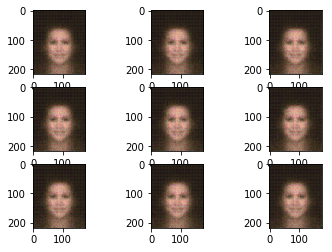

In [14]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

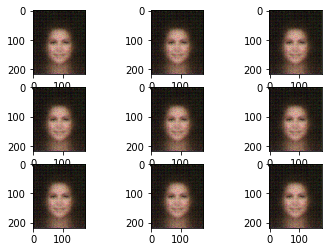

In [17]:
gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])


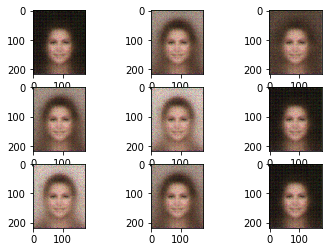

In [16]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_z})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

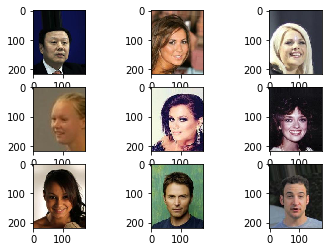

In [18]:
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg_batch])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [35]:
step = 500

Dreal_batch = sess.run(discriminator(x_d), feed_dict = {x_d: real_batch})
Dreal_pic = np.array([np.reshape(m,(218,178,3)) for m in Dreal_batch])
real_pic = np.array([np.reshape(m,(218,178,3)) for m in real_batch])

fake_pic = np.array([np.reshape(m,(218,178,3)) for m in sess.run(g_sample, feed_dict = {x_g: z_sample})])
Dfake_pic = np.array([np.reshape(m,(218,178,3)) for m in sess.run(discriminator(g_sample), feed_dict = {x_g: z_sample})])

fig = plt.figure(figsize=(8,2))

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(real_pic[i])
    plt.axis('off')
    plt.subplot(2, 10, i+1+10)
    plt.imshow(Dreal_pic[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('real_Dreal_'+str(step)+'.png', bbox_inches='tight', pad_inches = 0)

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(fake_pic[i])
    plt.axis('off')
    plt.subplot(2, 10, i+1+10)
    plt.imshow(Dfake_pic[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('fake_Dfake_'+str(step)+'.png', bbox_inches='tight', pad_inches = 0)

NameError: name 'n' is not defined